<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


In [43]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

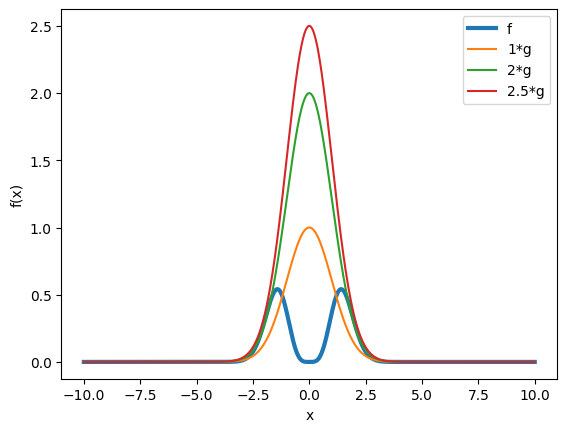

In [44]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)
M = [1, 2, 2.5]

plt.figure()
plt.plot(x, f(x), label='f', linewidth=3)
for m in M :
    plt.plot(x, np.round(m, 2) * g(x), label=f'{np.round(m, 2)}*g')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

For **$M = 2,5$**, $Mg \geq f$. For the rest of the project, we will take this value of $M$.

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [45]:
def rejection_sampling(f, g, M, N):
    """Reject sampling algorithm for f with Gaussian proposal g."""

    accepted_samples = [] # accepted samples
    
    for i in range(N) :
        scale = np.random.uniform()
        sample = np.random.normal()

        prop = scale * M * g(sample)
        target = f(sample)
        if target >= prop :
            accepted_samples.append(sample)
        
    return accepted_samples


In [46]:
# parameters
a = -4
b = 4
M = 2.5
p = 1_000
N = 100_000
x = np.linspace(a, b, p)
normalized_f = f(x) / scipy.integrate.quad(f, a, b)[0]

# applying the rejection sampling algorithm
accepted_samples = rejection_sampling(f, g, M, N)

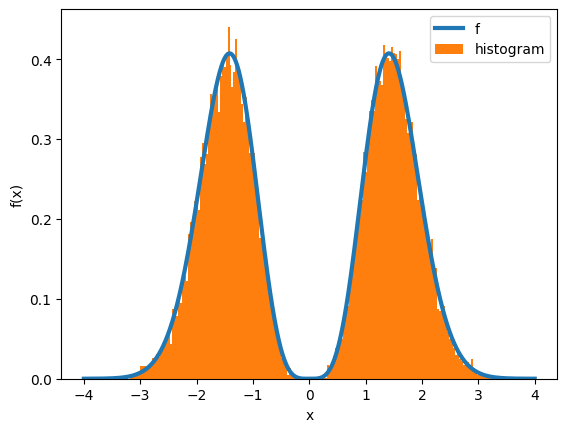

Acceptance rate :  21.47 %


In [47]:
# plotting the estimated density
plt.figure()
plt.plot(x, normalized_f, label='f', linewidth=3)
plt.hist(accepted_samples, bins = 200, label='histogram', density=True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

print("Acceptance rate : ", np.round(len(accepted_samples) / N * 100, 2), "%")

As we can observe, the acceptance rate is quite low. This means that a lot of samples are rejected and useless for the density estimation. This is due to the chosen density g. It concentrates samples around $0$, where the density $f$ is low. This leads to a lot of rejection and to a high number of samples required to estimate the density $f$.<br>
The main problem of this is that it can increase a lot the computation time.

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [48]:
def rw_metropolis_hastings(f, N, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    if seed is not None:
        np.random.seed(seed)

    sigma = 1
    x = 1.5

    for i in range(N) :
        x_new = x + np.random.normal(loc = 0, scale=sigma)

        alpha = f(x_new) / f(x)
        u = np.random.uniform()

        if alpha > u :
            accepted_samples.append(x_new)
            x = x_new
    return accepted_samples



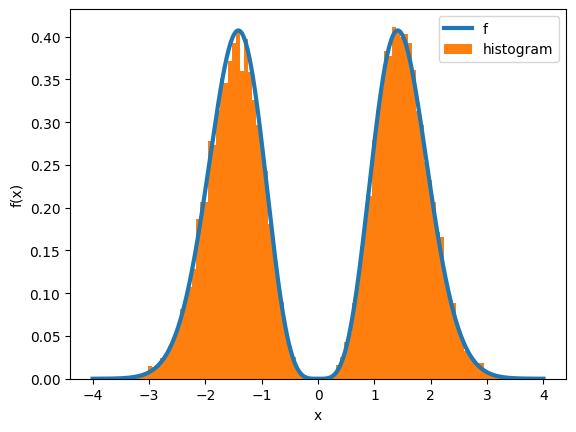

In [49]:
# parameters
a = -4
b = 4
p = 1_000
N = 10_000
x = np.linspace(a, b, p)

# plotting the estimated density
histogram_metropolis = []
histogram_metropolis = rw_metropolis_hastings(f, N, 0)
plt.figure()
plt.plot(x, normalized_f, label='f', linewidth=3)
plt.hist(histogram_metropolis, bins = 100, label='histogram', density = True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

Let's denote $x = (x_1, x_2)$, $\Gamma$ the covariance matrix of $(X_1, X_2)$ and $m$ the expectation vector.<br>

We have :  

$p(x) = \left.\frac{1}{2\pi} \frac{1}{\sqrt{\operatorname{det}(\Gamma)}} \exp \left(-1 / 2(x-m)^T \Gamma^{-1}(x-m)\right)\right) \text {. }$

Identifying the parameters, we find :

$$\Gamma^{-1} = \frac{1}{1-p^{2}}
\left(\begin{array}{l} 1 & -\rho \\
-\rho & 1
\end{array}\right)$$
and $$m = \left(
\begin{array}{l}
0\\
0 
\end{array}
\right)$$

So we have :

$$\Gamma = \left(
\begin{array}{l}
1 & \rho \\
\rho & 1
\end{array}
\right)$$

Hence,
$$(X_{1}, X_{2}) \sim \mathcal{N}\left(
\left(\begin{array}{l}
0\\
0 
\end{array}\right), 
\left(\begin{array}{l}
1 & \rho \\
\rho & 1
\end{array}\right)
\right)$$

Let's compute the conditional distribution of each component, denoted by : $p(X_1|X_2)$ and $p(X_2|X_1)$.

$$\begin{align}
p(x_{1}|x_{2}) 
&= \frac{p(x_{1},x_{2})}{\int p(x_{1},x_{2})\text{d}x_{1}} \\
&= \frac{\exp\left(\frac{-1}{2(1-\rho^2 )}(x_{1}^{2} + x_{2}^{2} - 2 \rho x_{1}x_{2} + \rho^{2}x_{2}^{2})\right)}{\int\exp\left(\frac{-1}{2(1-\rho^{2} )}(x_{1}^{2} + x_{2}^{2} - 2 \rho x_{1}x_{2} + \rho^{2}x_{2}^{2})\right)\text{dx}_{1}} \\
&= \frac{\exp\left(\frac{-1}{2(1-\rho^2 )}(x_{1} - \rho x_{2})^{2}\right)}{\int\exp\left(\frac{-1}{2(1-\rho^{2} )}(x_{1} - \rho x_{2})^{2}\right)\text{dx}_{1}} 
\end{align}$$

As $X_1, X_2$ have a symmetric role, we get :

$$\begin{aligned}
& X_1  \mid(X_2=x_2) \sim N\left(\rho x_2, 1-\rho^2\right) \\
& X_2  \mid(X_1=x_1) \sim N\left(\rho x_1, 1-\rho^2\right)
\end{aligned}$$



*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [50]:
# implementing the density function of (X_1, X_2)
def p(x_1, x_2, rho) :
    return np.exp(- 0.5 * (x_1 ** 2 + x_2 ** 2- 2 * rho * x_1 * x_2) / (1 - rho ** 2)) / (2 * np.pi * np.sqrt(1 - rho ** 2))

In [51]:
def gibbs_sampler(N, rho):
    """Gibbs sampler for (X_1, X_2)."""
    
    (x_1, x_2) = (0, 0)
    X = [(x_1, x_2)]

    for i in range(N) :
        x_1 = np.random.normal(loc = rho * x_2, scale = 1 - rho**2)
        x_2 = np.random.normal(loc = rho * x_2, scale = 1 - rho**2)
        X.append((x_1, x_2))
    return X

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

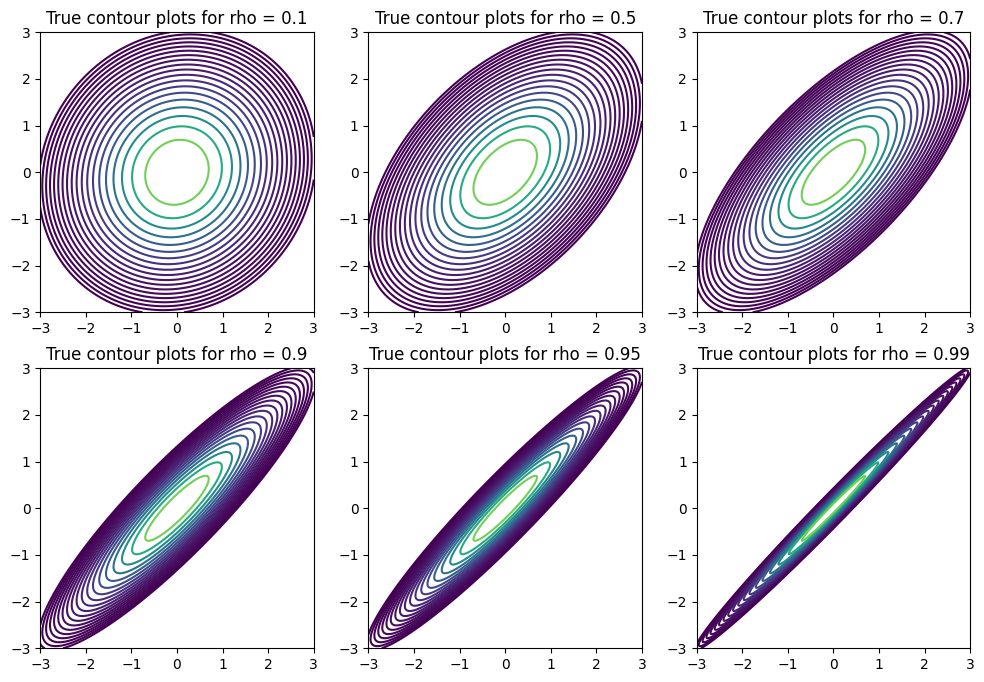

In [52]:
from scipy.stats import multivariate_normal

# parameters
N = 100_000
rho_array = [[0.1, 0.5, 0.7], 
           [0.9, 0.95, 0.99]]

# plotting contour plots given different rho values
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for (i, j) in [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] :
    S = np.array([[1, rho_array[i][j]], [rho_array[i][j], 1]])
    grid = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(grid, grid)
    pos = np.empty((1000, 1000, 2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    ax[i][j].contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
    ax[i][j].set_title(f"True contour plots for rho = {rho_array[i][j]}")
plt.show()

As expected, as $\rho$ increases, the ``contour plot`` gets thiner, reducing the variance of the distribution.

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

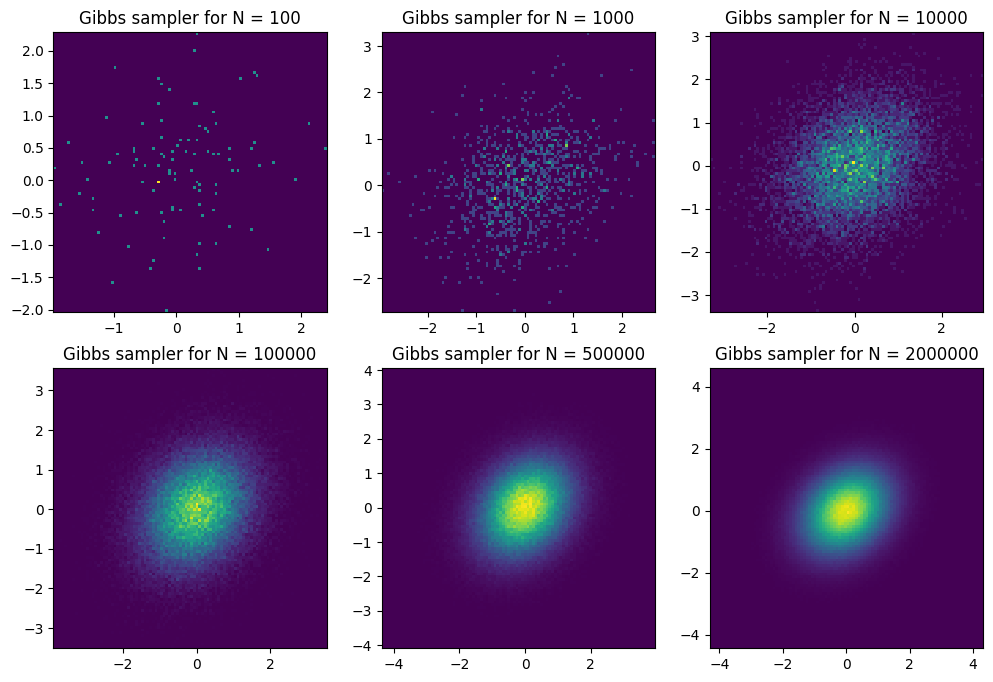

In [53]:
# parameters
rho = 0.5

# plot the 2D histogram first to see the evolution of the Gibbs sampler with N
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
N_array = [[100, 1_000, 10_000], 
           [100_000, 500_000, 2_000_000]]
for (i, j) in [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] :
    X = gibbs_sampler(N_array[i][j], rho)
    X_1 = [x[0] for x in X]
    X_2 = [x[1] for x in X]
    ax[i][j].hist2d(X_1, X_2, bins=100, density=True)
    ax[i][j].set_title(f"Gibbs sampler for N = {N_array[i][j]}")
plt.show()

It is interesting to see the convergence towards the target distribution with the 2D histogram.

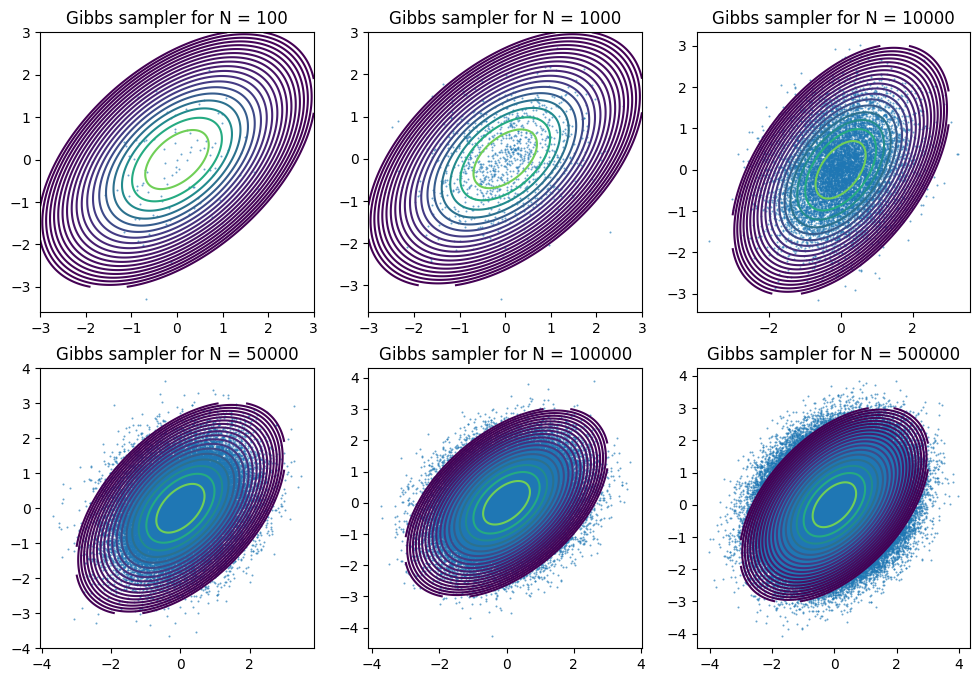

In [54]:
# parameters
N_array = [[100, 1_000, 10_000], 
           [50_000, 100_000, 500_000]]
rho = 0.5

# plotting the contour plots
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for (i, j) in [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] :
    X = gibbs_sampler(N_array[i][j], rho)
    X_1 = [x[0] for x in X]
    X_2 = [x[1] for x in X]

    # contour plot for rho = 0.5
    S = np.array([[1, rho], [rho, 1]])
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    ax[i][j].contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())

    ax[i][j].scatter(X_1, X_2, linewidths=0.5, s=1, alpha=0.5)
    ax[i][j].set_title(f"Gibbs sampler for N = {N_array[i][j]}")
plt.show()

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

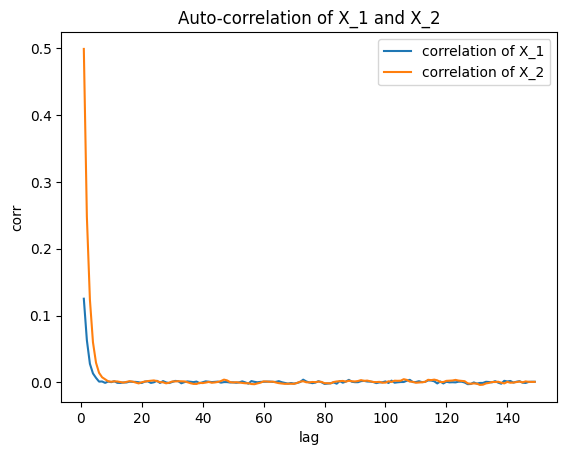

In [55]:
# auto-correlation functiion as a function of the lag using numpy.corrcoef
def corr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

# parameters
N = 100_000
rho = 0.5

lag = np.arange(1, 150, 1)
autocorr_1 = [corr(X_1, t=t0)[0][1] for t0 in lag]
autocorr_2 = [corr(X_2, t=t0)[0][1] for t0 in lag]

# plotting the auto-correlation function
plt.figure()
plt.plot(lag, autocorr_1, label='correlation of X_1')
plt.plot(lag, autocorr_2, label='correlation of X_2')
plt.xlabel('lag')
plt.ylabel('corr')
plt.legend()
plt.title("Auto-correlation of X_1 and X_2")
plt.show()

The correlation between samples decreases as the lag increases. Spacing samples from some lag can simulate independant samples.

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

As it takes about 20 interations to decorrelate the samples, we could add a step size that adds the samples only at each step. It would allow to simulate i.i.d samples.<br><br>
We could also add the parameter $\rho$, as it allows to simulate different version of the Gaussian distribution.

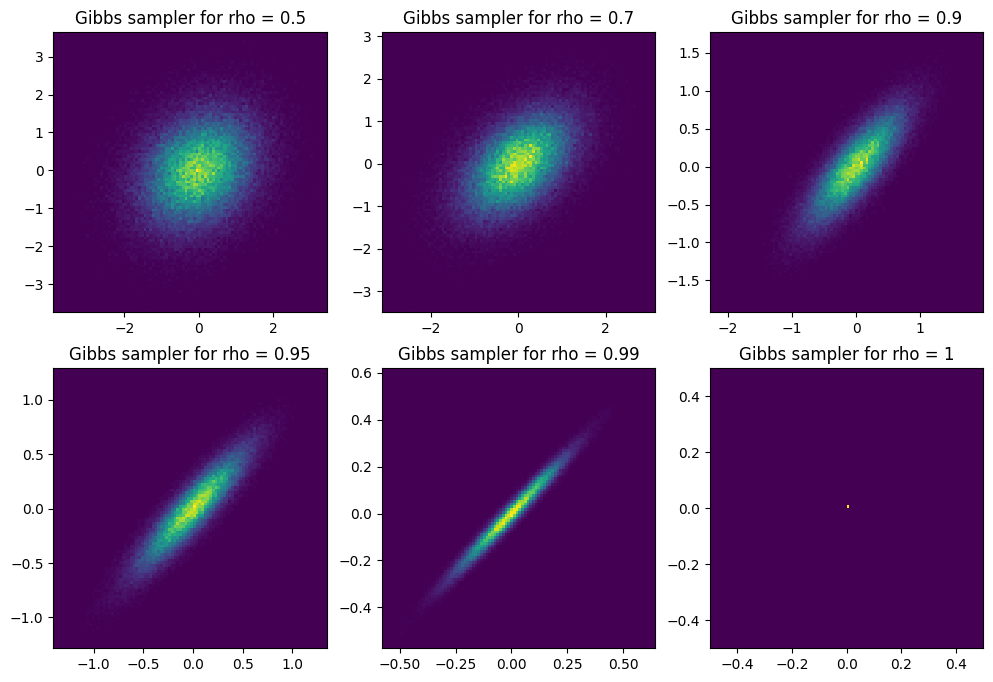

In [56]:
# plot the 2D histogram to see the evolution of the Gibbs sampler with rho
N = 100_000
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
rho_array = [[0.5, 0.7, 0.9], 
           [0.95, 0.99, 1]]

for (i, j) in [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] :
    X = gibbs_sampler(N, rho_array[i][j])
    X_1 = [x[0] for x in X]
    X_2 = [x[1] for x in X]
    ax[i][j].hist2d(X_1, X_2, bins=100, density=True)
    ax[i][j].set_title(f"Gibbs sampler for rho = {rho_array[i][j]}")
plt.show()


When $\rho$ tends to $1$, the variance is lower the ellipse observed is thiner. It tends to a constant distribution equal to the first sample.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

In [57]:
def rw_metropolis_hastings_two(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    if seed is not None:
        np.random.seed(seed)

    x = (1.5, 1.5)
    accepted_samples = [x]

    for i in range(n) :
        x_new = (x[0] + np.random.normal(loc = 0, scale=tau), x[1] + np.random.normal(loc = 0, scale=tau))
        alpha = f(x_new[0], x_new[1], tau) / f(x[0], x[1], tau)
        u = np.random.uniform()

        if alpha > u :
            accepted_samples.append(x_new)
            x = x_new
    
    return accepted_samples

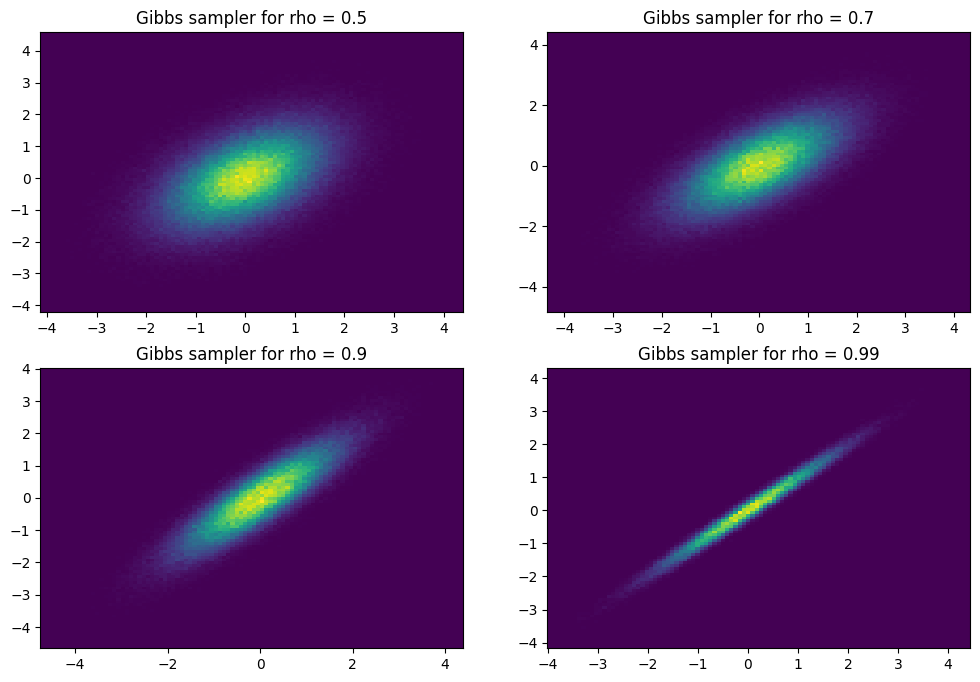

In [58]:
# plot the 2D histogram to see the evolution of the Random Walk metropolis hasting with rho
N = 500_000
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
rho_array = [[0.5, 0.7], 
           [0.9, 0.99]]
for i in [0, 1] :
    for j in [0, 1] :
        X = rw_metropolis_hastings_two(N, p, rho_array[i][j], 0)
        X_1 = [x[0] for x in X]
        X_2 = [x[1] for x in X]
        ax[i][j].hist2d(X_1, X_2, bins=100, density=True)
        ax[i][j].set_title(f"Gibbs sampler for rho = {rho_array[i][j]}")
plt.show()

We get similar results to the Gibbs sampler.